# 介绍

CIFAR-10是一个比较经典的多分类图像问题，之前在CS231n里面也有介绍实现这个任务，下面分为以下几个步骤进行实现

1. 使用torchvision来加载CIFAR-10数据集
2. 定义网络
3. 定义损失函数和优化器
4. 训练网络并更新参数
5. 测试网络


## 1、加载CIFAR-10数据集

In [1]:
# 利用torch里面自带的torchvision 加载图像方法，加载我们所需要的数据
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

In [2]:
#这个show可以将tensor转换成image,方便可视化
show = ToPILImage()

In [3]:
#自动下载CIFAR-10数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    #归一化
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
])

trainset = tv.datasets.CIFAR10(
                                root = '../../data/',
                                train = True,
                                download = True,
                                transform = transform
                              )
trainLoader = t.utils.data.DataLoader(trainset, batch_size = 4,shuffle = True,num_workers = 2)

testset = tv.datasets.CIFAR10(root = '../../data/',train = False, download = True, transform = transform)

testLoader = t.utils.data.DataLoader(testset, batch_size=4, shuffle= True, num_workers= 2)

#预先定义每个类所属的类别的英文名
classes = ('plane','car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### 可视化显示数据集

ship


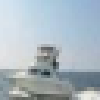

In [4]:
#提取出一张图片并查看这张图片所属的类别
(data, label) = trainset[100]
print(classes[label])

#采用图片查看器，show，重新对图片进行大小整合
show((data + 1) / 2 ).resize((100,100))

### trainLoader是一个可以迭代的对象，它将数据返回的数据样本拼成一个Batch，提供一系列的操作，dataLoader迭代一次遍历所有数据

       deer        bird        bird       truck


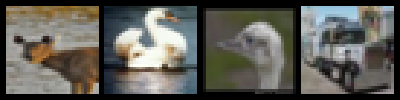

In [5]:
# 获取一个迭代器
dataiter = iter(trainLoader)

#获取第一个batch中的图像和标签
images, labels = dataiter.next()

# 这里控制标签的格式进行输出，11s表示每个标签之间间隔11个空格
print(' '.join('%11s'%classes[labels[j]]for j in range(4)))

# 利用可视化显示器进行图像显示，并将四张图像放在一个网格中
show(tv.utils.make_grid((images + 1) / 2)).resize((400,100))

## 2、定义网络

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
#搭建一个简单的神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        #定义卷积层，这里的参数和keras里面的参数不一致，3表示输入通道，6表示输出通道，5表示5*5的卷积核
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        
        #定义全连接层，16*5*5，将前面的卷积层得到的图像进行拉平
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self ,x):
        #第一次计算，卷积+激活函数
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        
        #全连接层
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3、定义损失函数和优化器

In [8]:
from torch import optim

### 和之前一样定义损失函数和优化器

In [9]:
crition = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.9)

## 4、训练网络并更新参数

In [10]:
#需要预先导入Variable
from torch.autograd import Variable

In [ ]:
flag = t.cuda.is_available()
flag = False

if flag:
    print('电脑支持cuda')
    net.cuda()
    
    for epoch in range(2):
        running_loss = 0.0

        for i ,data in enumerate(trainLoader, 0):
            #输入数据
            inputs, labels = data

            inputs, labels = inputs.cuda(), labels.cuda()
            #梯度置零
            optimizer.zero_grad()

            #前向传播
            outputs = net(Variable(inputs))
            #反向传播
            loss = crition(outputs, Variable(labels))
            loss.backward()
            optimizer.step()

            #对损失值进行累加
            running_loss += loss.item()
            #打印训练log信息
            if i / 2 == 0 :
                print('[%d, %d] loss :%.3f' %(epoch + 1, i+1, running_loss /200))
                running_loss = 0.0

        print('finish training!')

else:
     for epoch in range(2):
        running_loss = 0.0

        for i ,data in enumerate(trainLoader, 0):
            #输入数据
            inputs, labels = data

            inputs, labels = Variable(inputs), Variable(labels)
            #梯度置零
            optimizer.zero_grad()

            #前向传播
            outputs = net(inputs)
            #反向传播
            loss = crition(outputs, labels)
            loss.backward()
            optimizer.step()

            #对损失值进行累加
            running_loss += loss.item()
            #打印训练log信息
            if i / 2 == 0 :
                print('[%d, %d] loss :%.3f' %(epoch + 1, i+1, running_loss /200))
                running_loss = 0.0

        print('finish training!')


[1, 1] loss :0.012


## 5、测试网络

In [ ]:
# 用测试数据检验网络
dataiter = iter(testLoader)
images, labels = dataiter.next()
print ('实际的Label：',' '.join('%08s' % classes[labels[j]]for i in range(4)))
show(tv.utils.mark_grid(images / 2 - 0.5)).resize((400,100))


In [ ]:
# 利用网络计算目标图像各个类别得到的预测分数
outputs = net(Variable(images))

_, predicted = t.max(outputs.data, 1)
print ('预测的Label：',' '.join('%08s' % classes[predicted[j]]for i in range(4)))